In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bidi-reordered-dataset/bidi_reordered_attacked.csv
/kaggle/input/spelling-mistakes-dataset/mispelled_text.csv
/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv
/kaggle/input/zero-width/attacked_text.csv
/kaggle/input/watermarked-and-unwatermarked-text-truncated/data_trunk.csv
/kaggle/input/spellcheck-watermarked/corrected_text.csv


In [2]:
!git clone https://github.com/jthickstun/watermark.git

Cloning into 'watermark'...
remote: Enumerating objects: 80, done.
remote: Counting objects: 100% (80/80), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 80 (delta 25), reused 67 (delta 14), pack-reused 0
Unpacking objects: 100% (80/80), 264.81 KiB | 4.81 MiB/s, done.


In [3]:
import os
os.chdir("/kaggle/working/watermark/demo")

In [4]:
import os, sys, argparse, time

import numpy as np
from transformers import AutoTokenizer
from mersenne import mersenne_rng

import pyximport
pyximport.install(reload_support=True, language_level=sys.version_info[0],
                  setup_args={'include_dirs':np.get_include()})
from levenshtein import levenshtein

def permutation_test(tokens,key,n,k,vocab_size,n_runs=100):
    rng = mersenne_rng(key)
    xi = np.array([rng.rand() for _ in range(n*vocab_size)], dtype=np.float32).reshape(n,vocab_size)
    test_result = detect(tokens,n,k,xi)

    p_val = 0
    for run in range(n_runs):
        xi_alternative = np.random.rand(n, vocab_size).astype(np.float32)
        null_result = detect(tokens,n,k,xi_alternative)

        # assuming lower test values indicate presence of watermark
        p_val += null_result <= test_result

    return (p_val+1.0)/(n_runs+1.0)


def detect(tokens,n,k,xi,gamma=0.0):
    m = len(tokens)
    n = len(xi)

    A = np.empty((m-(k-1),n))
    for i in range(m-(k-1)):
        for j in range(n):
            A[i][j] = levenshtein(tokens[i:i+k],xi[(j+np.arange(k))%n],gamma)

    return np.min(A)


In file included from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarraytypes.h:1929,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/ndarrayobject.h:12,
                 from /opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/arrayobject.h:5,
                 from /root/.pyxbld/temp.linux-x86_64-cpython-310/kaggle/working/watermark/demo/levenshtein.c:1205:
/opt/conda/lib/python3.10/site-packages/numpy/core/include/numpy/npy_1_7_deprecated_api.h:17:2: warning: #warning "Using deprecated NumPy API, disable it with " "#define NPY_NO_DEPRECATED_API NPY_1_7_API_VERSION" [-Wcpp]
   17 | #warning "Using deprecated NumPy API, disable it with " \
      |  ^~~~~~~


In [5]:
from tqdm import tqdm
import pandas as pd
from sklearn.utils import shuffle

def main():
    # Read data from CSV using pandas
    data = pd.read_csv("/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv")

    # Read data from CSV
    data = pd.read_csv("/kaggle/input/unnecessary-whitespace-dataset/merged_data.csv")

    # Sample 70 watermarked and 70 unwatermarked rows
    watermarked_sample = data[data['label'] == 'watermarked'].sample(n=70, random_state=42)
    unwatermarked_sample = data[data['label'] == 'unwatermarked'].sample(n=70, random_state=42)

    # Drop the index for both samples
    watermarked_sample.reset_index(drop=True, inplace=True)
    unwatermarked_sample.reset_index(drop=True, inplace=True)

    # Merge the samples
    merged_samples = pd.concat([watermarked_sample, unwatermarked_sample], ignore_index=True)

    # Shuffle the merged samples
    shuffled_samples = shuffle(merged_samples, random_state=42).reset_index(drop=True)
    shuffled_samples.to_csv("/kaggle/working/Shuffled_samples.csv", index=False)
#     # Combine filtered data
#     split_point1 = int(len(data) / 3)
#     split_point2 = split_point1 * 2
#     split_point3 = 100
#     part1 = shuffled_samples.iloc[:100] # First part
#     part2 = shuffled_samples.iloc[35:69]  # Second part
#     part3 = shuffled_samples.iloc[69:100]  # Third part (might be slightly bigger)
    # Load pre-trained tokenizer (replace with your desired tokenizer)
    tokenizer = AutoTokenizer.from_pretrained("facebook/opt-350m")

    # Progress bar with tqdm
    results = []
    for index, row in tqdm(shuffled_samples.iterrows(), total=len(shuffled_samples)):
        text = row["Cleaned Text"] 
        actual_label = row['label'] 

        # Tokenize the text
        tokens = tokenizer.encode(text, return_tensors='pt', truncation=True, max_length=2048).numpy()[0]

        t0 = time.time()
        pval = permutation_test(tokens, 42, 256, len(tokens), len(tokenizer))
        label = "watermarked" if pval <= 0.01 else "unwatermarked"
        results.append({"text": text, "p-value": pval, "label": label, "actual_label": actual_label})
        print(f"Row {index+1} - p-value: {pval:.4f}, label: {label}, actual_label {actual_label} (elapsed time: {time.time()-t0:.2f}s)")

    # Create a pandas DataFrame from the results
    df_results = pd.DataFrame(results)
#     df_results.head(2)
    # Save the DataFrame (optional)
    df_results.to_csv("permutation_test_results_whitespace.csv", index=False)
if __name__ == '__main__':
    main()

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/644 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

  1%|          | 1/140 [01:18<3:00:47, 78.04s/it]

Row 1 - p-value: 0.1881, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.02s)


  1%|▏         | 2/140 [03:19<3:57:48, 103.39s/it]

Row 2 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 121.14s)


  2%|▏         | 3/140 [05:08<4:02:11, 106.07s/it]

Row 3 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 109.24s)


  3%|▎         | 4/140 [06:07<3:18:43, 87.67s/it] 

Row 4 - p-value: 0.0693, label: unwatermarked, actual_label unwatermarked (elapsed time: 59.47s)


  4%|▎         | 5/140 [07:55<3:33:48, 95.03s/it]

Row 5 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 108.07s)


  4%|▍         | 6/140 [09:46<3:44:15, 100.42s/it]

Row 6 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.88s)


  5%|▌         | 7/140 [11:02<3:24:45, 92.37s/it] 

Row 7 - p-value: 0.5050, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.81s)


  6%|▌         | 8/140 [12:46<3:31:00, 95.91s/it]

Row 8 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 103.48s)


  6%|▋         | 9/140 [14:01<3:15:30, 89.55s/it]

Row 9 - p-value: 0.5743, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.56s)


  7%|▋         | 10/140 [15:21<3:07:10, 86.39s/it]

Row 10 - p-value: 0.2970, label: unwatermarked, actual_label unwatermarked (elapsed time: 79.32s)


  8%|▊         | 11/140 [16:38<3:00:05, 83.76s/it]

Row 11 - p-value: 0.3069, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.80s)


  9%|▊         | 12/140 [18:28<3:15:47, 91.78s/it]

Row 12 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.11s)


  9%|▉         | 13/140 [20:15<3:23:37, 96.20s/it]

Row 13 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 106.38s)


 10%|█         | 14/140 [22:05<3:31:11, 100.57s/it]

Row 14 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 110.66s)


 11%|█         | 15/140 [23:23<3:15:12, 93.70s/it] 

Row 15 - p-value: 0.8119, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.77s)


 11%|█▏        | 16/140 [24:23<2:52:22, 83.41s/it]

Row 16 - p-value: 0.4851, label: unwatermarked, actual_label unwatermarked (elapsed time: 59.50s)


 12%|█▏        | 17/140 [26:18<3:10:29, 92.92s/it]

Row 17 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 115.05s)


 13%|█▎        | 18/140 [28:14<3:23:14, 99.96s/it]

Row 18 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 116.33s)


 14%|█▎        | 19/140 [29:32<3:08:00, 93.23s/it]

Row 19 - p-value: 0.4554, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.56s)


 14%|█▍        | 20/140 [30:50<2:57:15, 88.63s/it]

Row 20 - p-value: 0.9406, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.90s)


 15%|█▌        | 21/140 [32:34<3:04:52, 93.21s/it]

Row 21 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 103.90s)


 16%|█▌        | 22/140 [33:51<2:54:18, 88.63s/it]

Row 22 - p-value: 0.0594, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.95s)


 16%|█▋        | 23/140 [35:56<3:13:38, 99.30s/it]

Row 23 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 124.18s)


 17%|█▋        | 24/140 [37:49<3:20:04, 103.49s/it]

Row 24 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.25s)


 18%|█▊        | 25/140 [39:04<3:02:10, 95.05s/it] 

Row 25 - p-value: 0.1485, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.35s)


 19%|█▊        | 26/140 [40:55<3:09:48, 99.90s/it]

Row 26 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 111.22s)


 19%|█▉        | 27/140 [42:11<2:54:35, 92.71s/it]

Row 27 - p-value: 0.0891, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.92s)


 20%|██        | 28/140 [43:18<2:38:15, 84.78s/it]

Row 28 - p-value: 0.3366, label: unwatermarked, actual_label unwatermarked (elapsed time: 66.27s)


 21%|██        | 29/140 [45:13<2:53:39, 93.87s/it]

Row 29 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 115.08s)


 21%|██▏       | 30/140 [47:03<3:01:11, 98.83s/it]

Row 30 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.41s)


 22%|██▏       | 31/140 [48:57<3:07:55, 103.45s/it]

Row 31 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 114.21s)


 23%|██▎       | 32/140 [50:14<2:51:29, 95.28s/it] 

Row 32 - p-value: 0.8119, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.20s)


 24%|██▎       | 33/140 [51:31<2:40:22, 89.93s/it]

Row 33 - p-value: 0.0099, label: watermarked, actual_label unwatermarked (elapsed time: 77.45s)


 24%|██▍       | 34/140 [52:35<2:24:52, 82.00s/it]

Row 34 - p-value: 0.3564, label: unwatermarked, actual_label unwatermarked (elapsed time: 63.51s)


 25%|██▌       | 35/140 [54:28<2:40:02, 91.45s/it]

Row 35 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.49s)


 26%|██▌       | 36/140 [56:12<2:45:03, 95.23s/it]

Row 36 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 104.03s)


 26%|██▋       | 37/140 [57:27<2:32:52, 89.05s/it]

Row 37 - p-value: 0.3762, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.64s)


 27%|██▋       | 38/140 [58:45<2:25:38, 85.67s/it]

Row 38 - p-value: 0.1782, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.79s)


 28%|██▊       | 39/140 [1:00:37<2:37:45, 93.71s/it]

Row 39 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 112.48s)


 29%|██▊       | 40/140 [1:02:30<2:45:53, 99.54s/it]

Row 40 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.12s)


 29%|██▉       | 41/140 [1:04:26<2:52:08, 104.33s/it]

Row 41 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 115.51s)


 30%|███       | 42/140 [1:06:23<2:56:58, 108.35s/it]

Row 42 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 117.73s)


 31%|███       | 43/140 [1:08:21<2:59:31, 111.04s/it]

Row 43 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 117.32s)


 31%|███▏      | 44/140 [1:10:15<2:59:11, 112.00s/it]

Row 44 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 114.22s)


 32%|███▏      | 45/140 [1:11:32<2:40:55, 101.64s/it]

Row 45 - p-value: 0.4851, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.46s)


 33%|███▎      | 46/140 [1:12:47<2:26:19, 93.40s/it] 

Row 46 - p-value: 0.7525, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.18s)


 34%|███▎      | 47/140 [1:13:46<2:09:00, 83.23s/it]

Row 47 - p-value: 0.4752, label: unwatermarked, actual_label unwatermarked (elapsed time: 59.48s)


 34%|███▍      | 48/140 [1:15:33<2:18:23, 90.25s/it]

Row 48 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 106.64s)


 35%|███▌      | 49/140 [1:17:26<2:27:29, 97.25s/it]

Row 49 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.58s)


 36%|███▌      | 50/140 [1:19:14<2:30:30, 100.33s/it]

Row 50 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 107.52s)


 36%|███▋      | 51/140 [1:20:18<2:12:49, 89.55s/it] 

Row 51 - p-value: 0.2673, label: unwatermarked, actual_label unwatermarked (elapsed time: 64.38s)


 37%|███▋      | 52/140 [1:22:12<2:21:58, 96.80s/it]

Row 52 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.71s)


 38%|███▊      | 53/140 [1:24:10<2:29:31, 103.12s/it]

Row 53 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 117.87s)


 39%|███▊      | 54/140 [1:25:26<2:16:19, 95.11s/it] 

Row 54 - p-value: 0.1881, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.41s)


 39%|███▉      | 55/140 [1:26:43<2:06:52, 89.56s/it]

Row 55 - p-value: 0.3069, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.62s)


 40%|████      | 56/140 [1:28:00<2:00:09, 85.83s/it]

Row 56 - p-value: 0.1386, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.11s)


 41%|████      | 57/140 [1:29:43<2:05:56, 91.04s/it]

Row 57 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 103.20s)


 41%|████▏     | 58/140 [1:31:33<2:12:10, 96.72s/it]

Row 58 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 109.95s)


 42%|████▏     | 59/140 [1:32:50<2:02:39, 90.86s/it]

Row 59 - p-value: 0.5347, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.18s)


 43%|████▎     | 60/140 [1:34:08<1:56:01, 87.02s/it]

Row 60 - p-value: 0.3267, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.06s)


 44%|████▎     | 61/140 [1:36:00<2:04:13, 94.35s/it]

Row 61 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 111.45s)


 44%|████▍     | 62/140 [1:37:50<2:08:43, 99.02s/it]

Row 62 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 109.93s)


 45%|████▌     | 63/140 [1:39:06<1:58:07, 92.05s/it]

Row 63 - p-value: 0.6634, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.77s)


 46%|████▌     | 64/140 [1:40:47<2:00:19, 94.99s/it]

Row 64 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 101.86s)


 46%|████▋     | 65/140 [1:42:05<1:52:19, 89.86s/it]

Row 65 - p-value: 0.2178, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.88s)


 47%|████▋     | 66/140 [1:43:56<1:58:33, 96.13s/it]

Row 66 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.77s)


 48%|████▊     | 67/140 [1:45:46<2:02:00, 100.28s/it]

Row 67 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 109.96s)


 49%|████▊     | 68/140 [1:47:02<1:51:38, 93.04s/it] 

Row 68 - p-value: 0.5248, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.14s)


 49%|████▉     | 69/140 [1:48:48<1:54:36, 96.85s/it]

Row 69 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 105.73s)


 50%|█████     | 70/140 [1:50:31<1:55:09, 98.71s/it]

Row 70 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 103.07s)


 51%|█████     | 71/140 [1:51:46<1:45:18, 91.57s/it]

Row 71 - p-value: 0.2871, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.88s)


 51%|█████▏    | 72/140 [1:53:03<1:38:48, 87.19s/it]

Row 72 - p-value: 0.3861, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.97s)


 52%|█████▏    | 73/140 [1:54:52<1:44:44, 93.80s/it]

Row 73 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 109.21s)


 53%|█████▎    | 74/140 [1:56:34<1:46:02, 96.40s/it]

Row 74 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 102.48s)


 54%|█████▎    | 75/140 [1:58:18<1:46:51, 98.63s/it]

Row 75 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 103.84s)


 54%|█████▍    | 76/140 [1:59:32<1:37:13, 91.15s/it]

Row 76 - p-value: 0.4059, label: unwatermarked, actual_label unwatermarked (elapsed time: 73.70s)


 55%|█████▌    | 77/140 [2:01:17<1:40:05, 95.32s/it]

Row 77 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 105.04s)


 56%|█████▌    | 78/140 [2:03:02<1:41:34, 98.30s/it]

Row 78 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 105.26s)


 56%|█████▋    | 79/140 [2:04:00<1:27:40, 86.23s/it]

Row 79 - p-value: 0.1584, label: unwatermarked, actual_label unwatermarked (elapsed time: 58.07s)


 57%|█████▋    | 80/140 [2:05:17<1:23:18, 83.32s/it]

Row 80 - p-value: 0.1881, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.51s)


 58%|█████▊    | 81/140 [2:06:33<1:19:48, 81.16s/it]

Row 81 - p-value: 0.2079, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.13s)


 59%|█████▊    | 82/140 [2:07:49<1:16:48, 79.45s/it]

Row 82 - p-value: 0.1188, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.45s)


 59%|█████▉    | 83/140 [2:09:45<1:26:00, 90.53s/it]

Row 83 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 116.37s)


 60%|██████    | 84/140 [2:11:38<1:30:45, 97.24s/it]

Row 84 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 112.89s)


 61%|██████    | 85/140 [2:12:39<1:19:13, 86.42s/it]

Row 85 - p-value: 0.3267, label: unwatermarked, actual_label unwatermarked (elapsed time: 61.19s)


 61%|██████▏   | 86/140 [2:14:31<1:24:33, 93.96s/it]

Row 86 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 111.55s)


 62%|██████▏   | 87/140 [2:16:32<1:30:14, 102.16s/it]

Row 87 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 121.27s)


 63%|██████▎   | 88/140 [2:18:24<1:31:08, 105.15s/it]

Row 88 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 112.15s)


 64%|██████▎   | 89/140 [2:19:40<1:21:56, 96.41s/it] 

Row 89 - p-value: 0.3762, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.00s)


 64%|██████▍   | 90/140 [2:20:57<1:15:35, 90.71s/it]

Row 90 - p-value: 0.1188, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.42s)


 65%|██████▌   | 91/140 [2:22:58<1:21:27, 99.74s/it]

Row 91 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 120.81s)


 66%|██████▌   | 92/140 [2:24:16<1:14:29, 93.12s/it]

Row 92 - p-value: 0.1980, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.65s)


 66%|██████▋   | 93/140 [2:25:33<1:09:10, 88.31s/it]

Row 93 - p-value: 0.4356, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.11s)


 67%|██████▋   | 94/140 [2:26:47<1:04:29, 84.11s/it]

Row 94 - p-value: 0.2970, label: unwatermarked, actual_label unwatermarked (elapsed time: 74.30s)


 68%|██████▊   | 95/140 [2:28:44<1:10:28, 93.96s/it]

Row 95 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 116.93s)


 69%|██████▊   | 96/140 [2:30:29<1:11:16, 97.20s/it]

Row 96 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 104.76s)


 69%|██████▉   | 97/140 [2:31:37<1:03:21, 88.41s/it]

Row 97 - p-value: 0.7624, label: unwatermarked, actual_label unwatermarked (elapsed time: 67.89s)


 70%|███████   | 98/140 [2:33:45<1:10:16, 100.39s/it]

Row 98 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 128.34s)


 71%|███████   | 99/140 [2:35:03<1:03:58, 93.63s/it] 

Row 99 - p-value: 0.1782, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.86s)


 71%|███████▏  | 100/140 [2:36:54<1:05:50, 98.77s/it]

Row 100 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.77s)


 72%|███████▏  | 101/140 [2:38:10<59:46, 91.96s/it]  

Row 101 - p-value: 0.6634, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.06s)


 73%|███████▎  | 102/140 [2:39:27<55:29, 87.63s/it]

Row 102 - p-value: 0.1980, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.51s)


 74%|███████▎  | 103/140 [2:40:46<52:19, 84.86s/it]

Row 103 - p-value: 0.9307, label: unwatermarked, actual_label unwatermarked (elapsed time: 78.39s)


 74%|███████▍  | 104/140 [2:42:03<49:27, 82.43s/it]

Row 104 - p-value: 0.2970, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.76s)


 75%|███████▌  | 105/140 [2:43:53<53:03, 90.97s/it]

Row 105 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.89s)


 76%|███████▌  | 106/140 [2:45:47<55:21, 97.68s/it]

Row 106 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.33s)


 76%|███████▋  | 107/140 [2:47:04<50:16, 91.42s/it]

Row 107 - p-value: 0.2376, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.80s)


 77%|███████▋  | 108/140 [2:49:19<55:44, 104.52s/it]

Row 108 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 135.09s)


 78%|███████▊  | 109/140 [2:50:35<49:36, 96.02s/it] 

Row 109 - p-value: 0.6436, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.18s)


 79%|███████▊  | 110/140 [2:51:56<45:43, 91.44s/it]

Row 110 - p-value: 0.0891, label: unwatermarked, actual_label unwatermarked (elapsed time: 80.74s)


 79%|███████▉  | 111/140 [2:53:16<42:34, 88.08s/it]

Row 111 - p-value: 0.1188, label: unwatermarked, actual_label unwatermarked (elapsed time: 80.25s)


 80%|████████  | 112/140 [2:55:34<48:07, 103.11s/it]

Row 112 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 138.18s)


 81%|████████  | 113/140 [2:56:48<42:25, 94.26s/it] 

Row 113 - p-value: 0.3960, label: unwatermarked, actual_label unwatermarked (elapsed time: 73.61s)


 81%|████████▏ | 114/140 [2:59:10<47:02, 108.57s/it]

Row 114 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 141.94s)


 82%|████████▏ | 115/140 [3:00:29<41:33, 99.74s/it] 

Row 115 - p-value: 0.0891, label: unwatermarked, actual_label unwatermarked (elapsed time: 79.15s)


 83%|████████▎ | 116/140 [3:02:22<41:34, 103.92s/it]

Row 116 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.67s)


 84%|████████▎ | 117/140 [3:04:13<40:36, 105.95s/it]

Row 117 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 110.67s)


 84%|████████▍ | 118/140 [3:05:29<35:32, 96.92s/it] 

Row 118 - p-value: 0.0891, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.85s)


 85%|████████▌ | 119/140 [3:07:22<35:37, 101.80s/it]

Row 119 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 113.18s)


 86%|████████▌ | 120/140 [3:09:22<35:45, 107.29s/it]

Row 120 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 120.11s)


 86%|████████▋ | 121/140 [3:10:42<31:19, 98.90s/it] 

Row 121 - p-value: 0.3465, label: unwatermarked, actual_label unwatermarked (elapsed time: 79.31s)


 87%|████████▋ | 122/140 [3:11:58<27:38, 92.13s/it]

Row 122 - p-value: 0.1782, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.32s)


 88%|████████▊ | 123/140 [3:14:02<28:47, 101.60s/it]

Row 123 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 123.72s)


 89%|████████▊ | 124/140 [3:16:03<28:41, 107.59s/it]

Row 124 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 121.54s)


 89%|████████▉ | 125/140 [3:18:08<28:13, 112.89s/it]

Row 125 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 125.27s)


 90%|█████████ | 126/140 [3:20:12<27:05, 116.11s/it]

Row 126 - p-value: 0.0198, label: unwatermarked, actual_label watermarked (elapsed time: 123.61s)


 91%|█████████ | 127/140 [3:22:03<24:50, 114.69s/it]

Row 127 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 111.38s)


 91%|█████████▏| 128/140 [3:23:21<20:43, 103.62s/it]

Row 128 - p-value: 0.1584, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.80s)


 92%|█████████▏| 129/140 [3:24:25<16:49, 91.79s/it] 

Row 129 - p-value: 0.3762, label: unwatermarked, actual_label unwatermarked (elapsed time: 64.18s)


 93%|█████████▎| 130/140 [3:25:42<14:32, 87.25s/it]

Row 130 - p-value: 0.5050, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.66s)


 94%|█████████▎| 131/140 [3:26:54<12:23, 82.56s/it]

Row 131 - p-value: 0.1683, label: unwatermarked, actual_label unwatermarked (elapsed time: 71.60s)


 94%|█████████▍| 132/140 [3:28:09<10:43, 80.40s/it]

Row 132 - p-value: 0.3960, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.35s)


 95%|█████████▌| 133/140 [3:29:20<09:03, 77.70s/it]

Row 133 - p-value: 0.2079, label: unwatermarked, actual_label unwatermarked (elapsed time: 71.39s)


 96%|█████████▌| 134/140 [3:30:37<07:44, 77.34s/it]

Row 134 - p-value: 0.0891, label: unwatermarked, actual_label unwatermarked (elapsed time: 76.52s)


 96%|█████████▋| 135/140 [3:32:26<07:13, 86.74s/it]

Row 135 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 108.67s)


 97%|█████████▋| 136/140 [3:33:43<05:36, 84.04s/it]

Row 136 - p-value: 0.7228, label: unwatermarked, actual_label unwatermarked (elapsed time: 77.74s)


 98%|█████████▊| 137/140 [3:34:59<04:04, 81.63s/it]

Row 137 - p-value: 0.6040, label: unwatermarked, actual_label unwatermarked (elapsed time: 75.99s)


 99%|█████████▊| 138/140 [3:36:45<02:57, 88.80s/it]

Row 138 - p-value: 0.0099, label: watermarked, actual_label watermarked (elapsed time: 105.53s)


 99%|█████████▉| 139/140 [3:37:53<01:22, 82.73s/it]

Row 139 - p-value: 0.4653, label: unwatermarked, actual_label unwatermarked (elapsed time: 68.57s)


100%|██████████| 140/140 [3:39:12<00:00, 93.95s/it]

Row 140 - p-value: 0.0099, label: watermarked, actual_label unwatermarked (elapsed time: 78.54s)


In [6]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

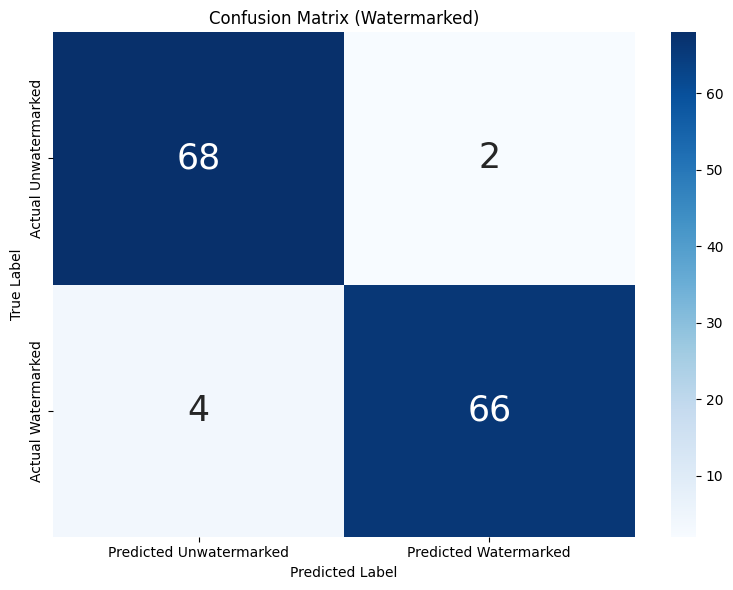


Classification Metrics:
Accuracy: 95.7143
F1-score: 95.7134
Precision: 95.7516
Recall: 95.7143


In [7]:
def evaluate_classification(file_path):

    # Evaluates a classification model using various metrics, reading data from a CSV file and creates a confusion matrix heatmap using seaborn.

    # Read the CSV file assuming 'label' and 'actual_label' columns are present
    df = pd.read_csv(file_path)

    # Extract true labels (assuming 'actual_label' column)
    y_true = df['actual_label'].tolist()

    # Extract predicted labels (assuming 'label' column)
    y_pred = df['label'].tolist()

    # Create the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Calculate accuracy
    accuracy = accuracy_score(y_true, y_pred)

    # Calculate F1-score
    f1 = f1_score(y_true, y_pred, average='weighted')

    # Calculate precision
    precision = precision_score(y_true, y_pred, average='weighted')

    # Calculate recall
    recall = recall_score(y_true, y_pred, average='weighted')
      # Define custom labels for the confusion matrix

    # Create a confusion matrix heatmap using seaborn
    plt.figure(figsize=(8, 6))
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='d',annot_kws={'fontsize': 25})
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('True Label')
    ax.set_title('Confusion Matrix (Watermarked)')
    plt.xticks([0.5, 1.5], ['Predicted Unwatermarked', 'Predicted Watermarked'])
    plt.yticks([0.5, 1.5], ['Actual Unwatermarked', 'Actual Watermarked'])    
    plt.tight_layout()
    plt.show()
    return cm, accuracy, f1, precision, recall

# Specify the file path (assuming you're using Kaggle)
file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"

# Evaluate the classification
cm, accuracy, f1, precision, recall = evaluate_classification(file_path)

# Print classification metrics (same as before)
print("\nClassification Metrics:")
print(f"Accuracy: {accuracy * 100:.4f}")
print(f"F1-score: {f1 * 100:.4f}")
print(f"Precision: {precision * 100:.4f}")
print(f"Recall: {recall * 100:.4f}")


In [8]:
def evaluate_misclassifications(file_path):
    # Evaluates the average absolute difference between misclassified p-values and the threshold (0.1) for watermarked images.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for misclassified watermarked images
    misclassified_watermarked = df[(df['label'] != df['actual_label']) & (df['actual_label'] == 'watermarked')]

    # Check if there are any misclassified watermarked images
    if len(misclassified_watermarked) == 0:
        print("No misclassified watermarked images found.")
        return None

    # Calculate absolute difference between misclassified p-values and the threshold (0.1)
    abs_diff = np.abs(misclassified_watermarked['p-value'] - 0.1)

    # Calculate average absolute difference
    average_diff = np.mean(abs_diff)

    return average_diff

# Specify the file path
file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"

# Evaluate misclassifications
average_diff = evaluate_misclassifications(file_path)

if average_diff is not None:
    print(f"Average absolute difference for misclassified watermarked images: {average_diff:.4f}")


Average absolute difference for misclassified watermarked images: 0.0802


In [9]:
def get_incorrect_samples(file_path):
   
    # Extracts all samples from a CSV file where 'label' and 'actual_label' differ.
    # Read the CSV file into a Pandas DataFrame
    df = pd.read_csv(file_path)

    # Filter for rows where label doesn't equal actual_label
    incorrect_samples = df[df['label'] != df['actual_label']]
    incorrect_samples = incorrect_samples.sort_values(by='actual_label')

    return incorrect_samples

file_path = "/kaggle/working/watermark/demo/permutation_test_results_whitespace.csv"
incorrect_df = get_incorrect_samples(file_path)


incorrect_df.head(len(incorrect_df))

,text,p-value,label,actual_label
32,How many times have you been to the beach?\nI'...,0.009901,watermarked,unwatermarked
139,Maize has been a staple in the world of farmin...,0.009901,watermarked,unwatermarked
12,Garbage should be collected daily or burnt. It...,0.019802,unwatermarked,watermarked
13,Some voters were non-residents of the communit...,0.019802,unwatermarked,watermarked
61,The project opportunities should be distribute...,0.019802,unwatermarked,watermarked
125,Women and young adults are advised to take on ...,0.019802,unwatermarked,watermarked
